In [1]:
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt

#设置中文字体，这部分需要在matplotlib中资源以及配置文件的调整，请自行搜索
import matplotlib as mpl
mpl.rcParams['font.family']=['sans-serif']
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
#iptables日志文件名
log_file_name = "data/iptables.log"

#获取文件数据，仅提取带有iptables前缀的记录
def get_lines_data(file_name, log_prefix):
    data = []
    with open(file_name, "r") as file:
        for line in file:
            if log_prefix in line:
                data.append(line.strip())
    return data

#输出按照空格分隔好的数据，仅仅提取其中带有"="的数据，
#并按照key/value的形式进行存放于字典中
#输入示例
# ['May', '24', '16:18:51', 'xxxxx', 'kernel:', 'port_forIN=eth0', 
#'OUT=', 'MAC=00:16:3e:30:6a:ff:ee:ff:ff:ff:ff:ff:08:00', 'SRC=1.2.3.4', 'DST=172.17.240.218', 
#'LEN=52', 'TOS=0x14', 'PREC=0x00', 'TTL=53', 'ID=50005', 'DF', 'PROTO=TCP', 'SPT=53176', 'DPT=24', 
#'WINDOW=64240', 'RES=0x00', 'SYN', 'URGP=0']

def convert_to_dic(one_record):
    dic = {}    
    for one_item in one_record:
        item_splited = one_item.split('=')
        key = item_splited[0]
        if len(item_splited) == 2:    
            value = item_splited[1]
        else:    
            value = ""
        dic[key] = value
    return dic


#iptables日志时间戳中没有年信息，必须自行添加
def convert_time(time_info):
    t = datetime.datetime.strptime(time_info,"%b %d %H:%M:%S")
    t = t.replace(year = 2020)
    return  str(t)


#处理一条日志，
def process_raw_iptable_data(one_line):
    
    #由于日志格式问题，Jul  1是两个空格，如果按照空格进行分割的话，会报错，这里使用比较粗暴的方法；
    #因为时间戳的字符串长度是固定的，所以直接按照偏移截断
    
    time_info = one_line[:15]
    splited_line = one_line[15:].split(" ")
    
    dic = convert_to_dic(splited_line[3:])
    
    dic['DPT'] = int(dic['DPT'])
    dic['time'] = convert_time(time_info)
    
    #仅关心日志中的时间，协议，目的端口，源IP
    res_dic = {
                "timestamp": dic['time'],
                "src_ip": dic['SRC'],
                "proto": dic['PROTO'],
                "dst_port": dic['DPT'],
            }
    return res_dic

In [3]:
#从源文件中读取原始数据
raw_iptables_log = get_lines_data(log_file_name, "port_for")
iptables_log = []
#将原始日志转化为pandas中的df格式
for one in raw_iptables_log:
    iptables_log.append(process_raw_iptable_data(one))
ip_log_df = pd.DataFrame(iptables_log)
#去除日志中UDP日志
ip_log_df = ip_log_df[ip_log_df['proto'] == "TCP"]

In [4]:
#设置日志中的timestamp为时间索引
ip_log_df['time'] = pd.to_datetime(ip_log_df['timestamp'])
ip_log_df.set_index("time", inplace =True)
ip_log_df.drop(['timestamp'],axis = 1, inplace = True)

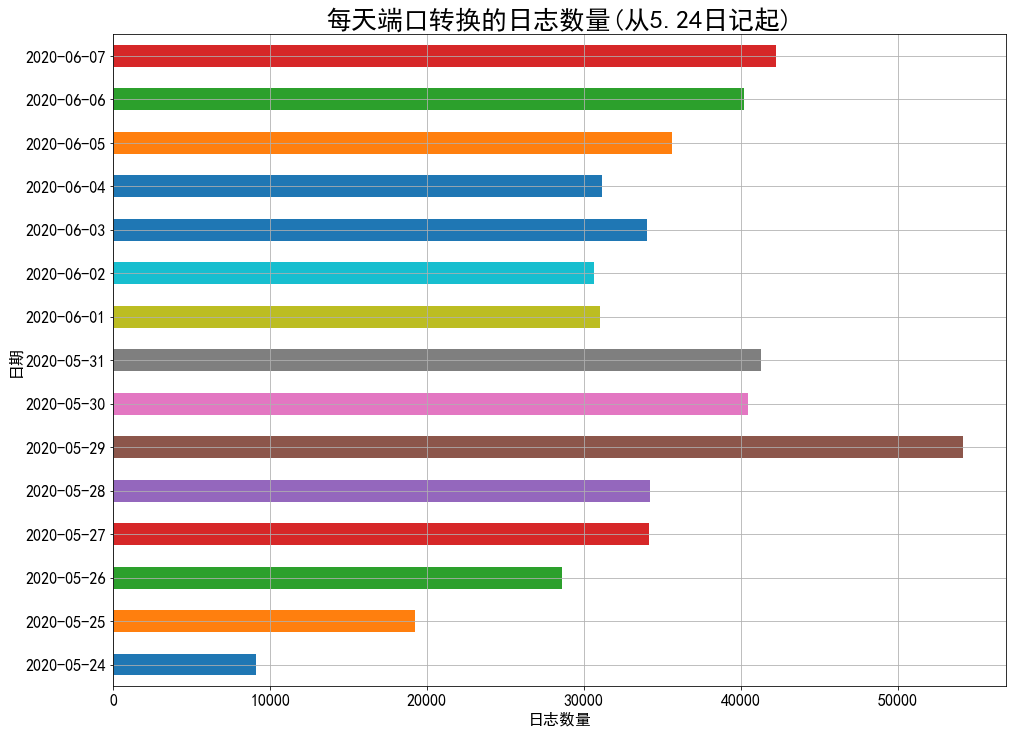

In [5]:
#按照日期统计整体数量
ip_log_df_byD = ip_log_df.resample("D").count()

#提取时间戳作为横轴上的标记，使用默认索引会增加后面的00:00，不美观
yticks = map(lambda x : str(x)[:-9], ip_log_df_byD.index.tolist())
ip_log_df_byD.plot(y = "src_ip",  kind = 'barh',figsize = (16,12),grid = True,legend = False)

fontsize = 16

plt.yticks(np.arange(len(yticks)), yticks, fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.ylabel(u"日期",fontsize = fontsize)
plt.xlabel(u"日志数量", fontsize = fontsize)
plt.title(u"每天端口转换的日志数量(从5.24日记起)", fontsize = fontsize + 10)
plt.show()

In [6]:
#查看平均日志数量
ip_log_df_byD['2020-05-25':].describe()

,dst_port,proto,src_ip
count,14.000000,14.000000,14.000000
mean,35501.285714,35501.285714,35501.285714
std,8115.494965,8115.494965,8115.494965
min,19217.000000,19217.000000,19217.000000
25%,31059.000000,31059.000000,31059.000000
50%,34169.000000,34169.000000,34169.000000
75%,40399.750000,40399.750000,40399.750000
max,54194.000000,54194.000000,54194.000000


/usr/lib64/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


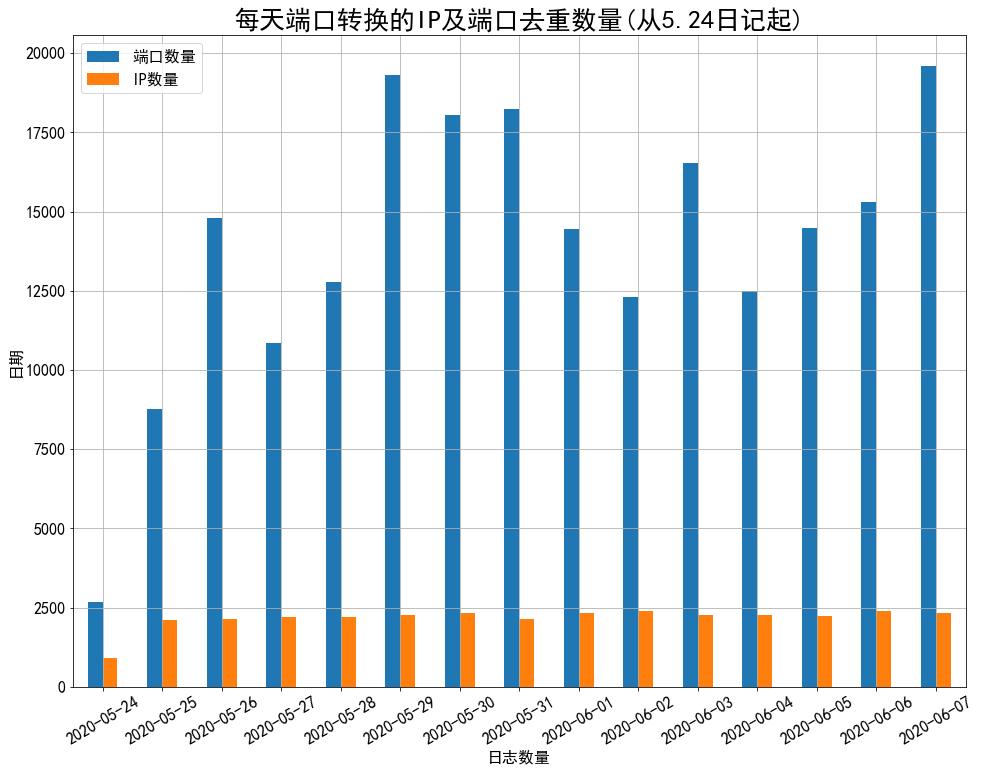

In [7]:
ip_log_df_byD_nuni = ip_log_df.resample("D").nunique()
#提取时间戳作为横轴上的标记，使用默认索引会增加后面的00:00，不美观
xticks = map(lambda x : str(x)[:-9], ip_log_df_byD_nuni.index.tolist())


ip_log_df_byD_nuni.plot(y = ['dst_port','src_ip'], 
                        kind = 'bar',figsize = (16,12),grid = True,rot = 30,
)

fontsize = 16

plt.xticks(np.arange(len(xticks)), xticks, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.ylabel(u"日期",fontsize = fontsize)
plt.xlabel(u"日志数量", fontsize = fontsize)
plt.title(u"每天端口转换的IP及端口去重数量(从5.24日记起)", fontsize = fontsize + 10)
plt.legend([u"端口数量",u"IP数量"],fontsize = fontsize)
plt.show()

Text(0,0.5,u'\u8bbf\u95ee\u6570\u91cf')

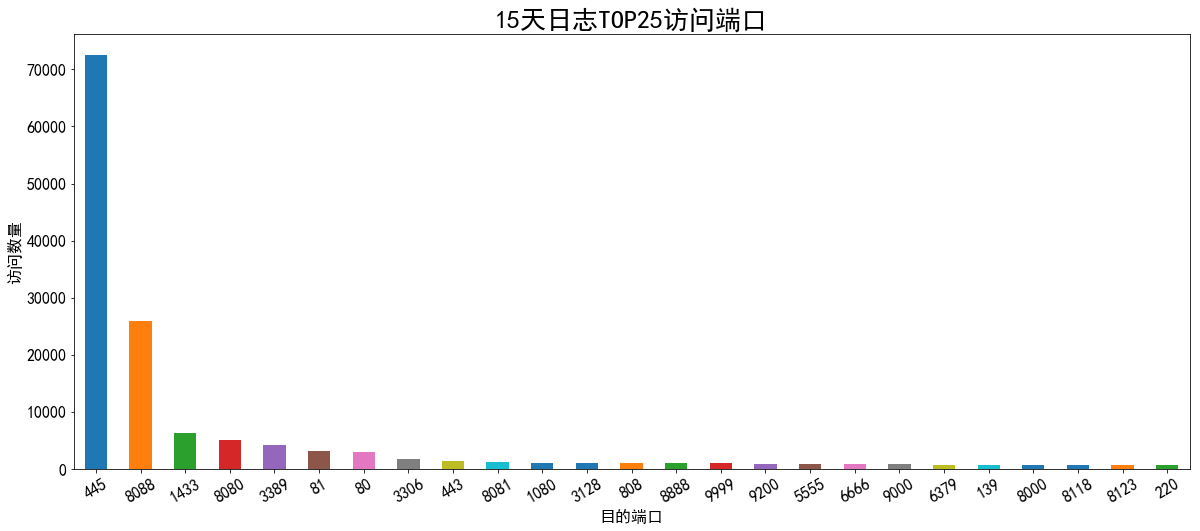

In [8]:
ip_log_df_byPort = ip_log_df.groupby('dst_port').count()
ip_log_df_byPort['proto'].sort_values(ascending = False)[:25].plot(kind = "bar",figsize = (20,8), fontsize = fontsize, rot = 30)
plt.title(u"15天日志TOP25访问端口",fontsize = fontsize + 10)
plt.xlabel(u"目的端口",fontsize = fontsize)
plt.ylabel(u"访问数量",fontsize = fontsize)


Text(0,0.5,u'\u8bbf\u95ee\u6570\u91cf')

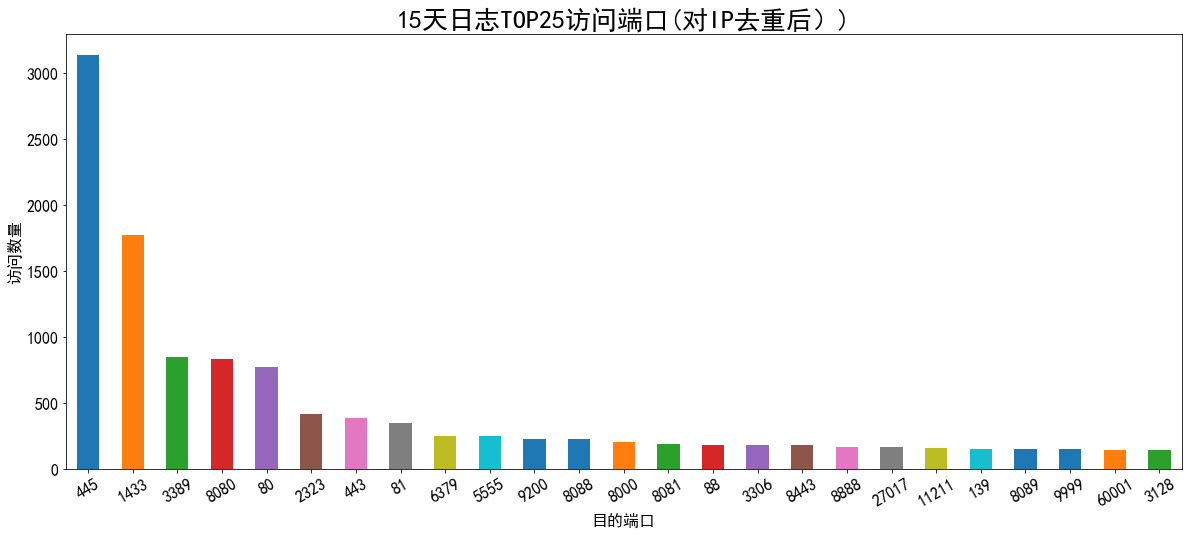

In [9]:
#按照端口聚合后对IP去重
dst_port_uniq_ip = ip_log_df.groupby("dst_port").agg(lambda x: x.unique().tolist())
dst_port_uniq_ip['count']  = dst_port_uniq_ip['src_ip'].apply(lambda x: len(x))


dst_port_uniq_ip.sort_values('count',ascending = False)[:25].plot(y = 'count',kind = 'bar',figsize = (20,8),
                                                                  legend = False,
                                                                  fontsize = fontsize, rot = 30)

plt.title(u"15天日志TOP25访问端口(对IP去重后）)",fontsize = fontsize + 10)
plt.xlabel(u"目的端口",fontsize = fontsize)
plt.ylabel(u"访问数量",fontsize = fontsize)

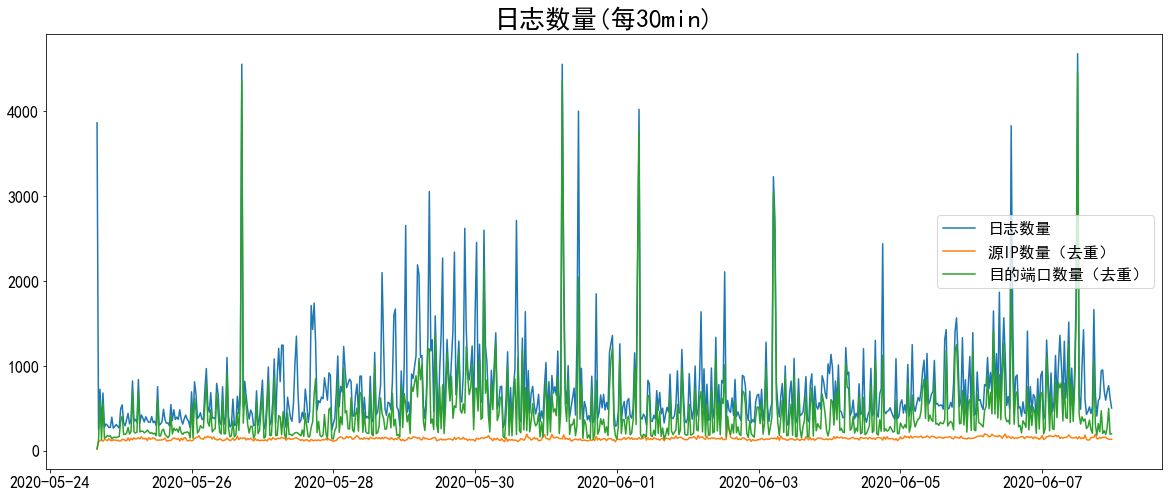

In [10]:
#绘制小时间区间的日志数量图像
def plot_by_time(df,time_str):
    resampled_df_count = df.resample(time_str).count()
    resampled_df_nunique = df.resample(time_str).nunique()
    
    plt.figure(figsize = (20,8))
    plt.plot(resampled_df_count.index, resampled_df_count['src_ip'], label = u"日志数量")
    plt.plot(resampled_df_count.index, resampled_df_nunique['src_ip'],label = u"源IP数量（去重）")
    plt.plot(resampled_df_count.index, resampled_df_nunique['dst_port'],label = u"目的端口数量（去重）")
    
    fontsize = 16
    plt.title(u"日志数量(每%s)" % time_str,fontsize = fontsize + 10)
    plt.legend(fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.show()
    
plot_by_time(ip_log_df,"30min")

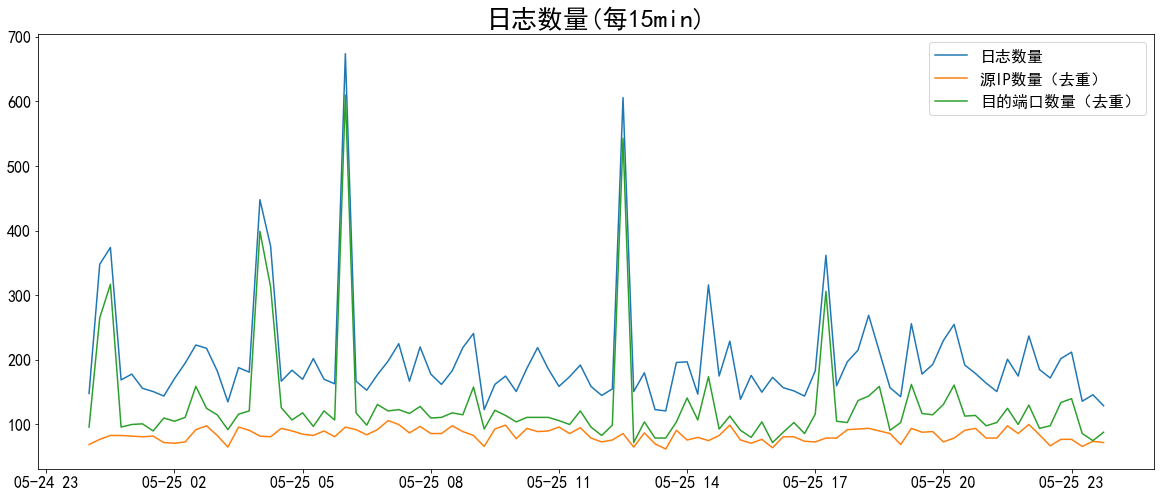

In [11]:
plot_by_time(ip_log_df["2020-05-25"],"15min")

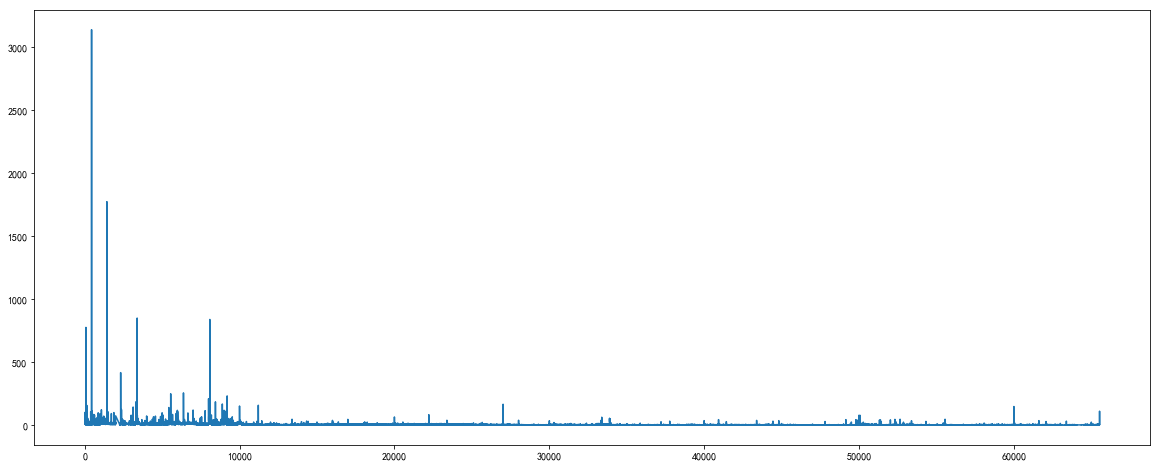

In [12]:
#端口分布（去重）
port_group  = ip_log_df.groupby(['dst_port']).nunique()
plt.figure(figsize = (20,8))
plt.plot(port_group.index, port_group['src_ip'])

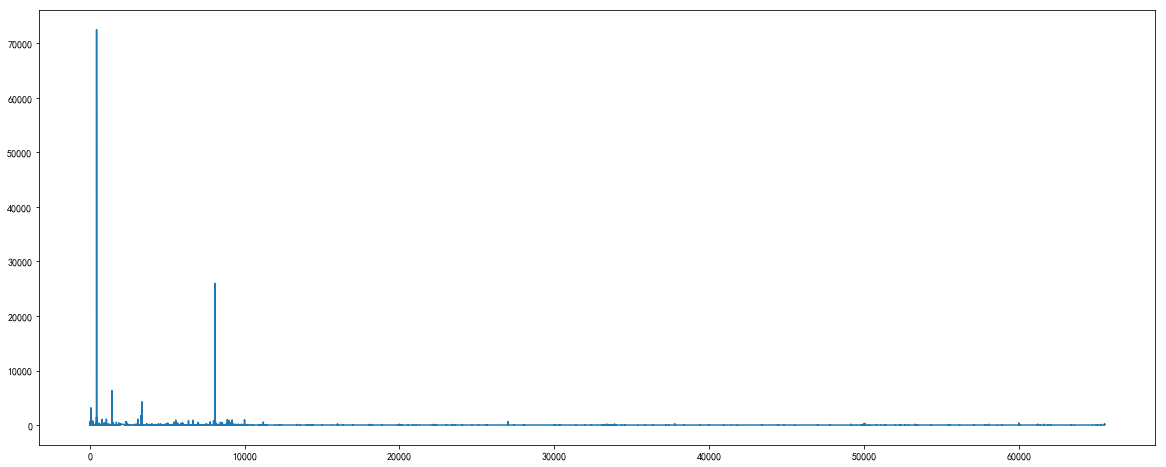

In [13]:
#端口日志数量分布
port_group_count  = ip_log_df.groupby(['dst_port']).count()
plt.figure(figsize = (20,8))
plt.plot(port_group_count.index, port_group_count['src_ip'])

In [14]:
#查看端口及IP增长速率

import copy
def plot_increase_figure(df, col_name):
    test = set()
    def test_apply(data):
        x = set(data.tolist())
        test.update(x)
        return copy.copy(test)

    res = df.resample("15min")[col_name].apply(test_apply)
    res.apply(lambda x: len(x)).plot(kind = "line")    

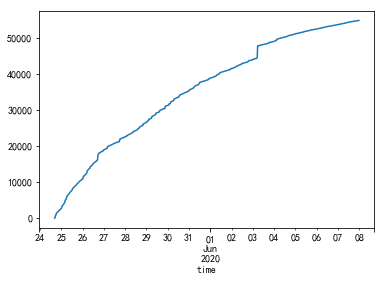

In [15]:
plot_increase_figure(ip_log_df,"dst_port")

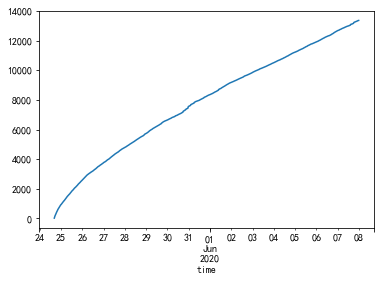

In [16]:
plot_increase_figure(ip_log_df,"src_ip")

In [17]:
import geoip2.database
from geoip2.errors import AddressNotFoundError
reader = geoip2.database.Reader("../../geo_ip_data/GeoLite2-City.mmdb")

In [18]:
all_ip_df = pd.DataFrame(ip_log_df['src_ip'].unique(),columns=['src_ip'])

In [19]:
#为每个IP获取相应的地域信息
def ip_info(x):
    ip = x.src_ip
    country = "Unknown"
    city = "Unknown"
    longitude = 0
    latitude = 0
    try:
        response = reader.city(ip)
    except AddressNotFoundError:
        return " ".join([country, city, "0", "0"])
    try:
        country = response.country.names['zh-CN'] #+ "-" + response.city.names['zh-CN']
    except KeyError:
        pass
    
    try:
        city = response.city.names['zh-CN']
    except KeyError:
        pass
    
    return " ".join([country, city, str(response.location.longitude), str(response.location.latitude)])

In [20]:
all_ip_df['loc'] = all_ip_df.apply(ip_info, axis = 1)

In [21]:
all_info = pd.merge(ip_log_df, all_ip_df, how = 'left', on='src_ip',left_index = True)


all_info['coutry'] = all_info.apply(lambda x: x['loc'].split(" ")[0], axis =1)
all_info['city'] = all_info.apply(lambda x: x['loc'].split(" ")[1], axis =1)
all_info['longitude'] = all_info.apply(lambda x: float(x['loc'].split(" ")[2]),axis =1)
all_info['latitude'] = all_info.apply(lambda x: float(x['loc'].split(" ")[3]), axis =1)

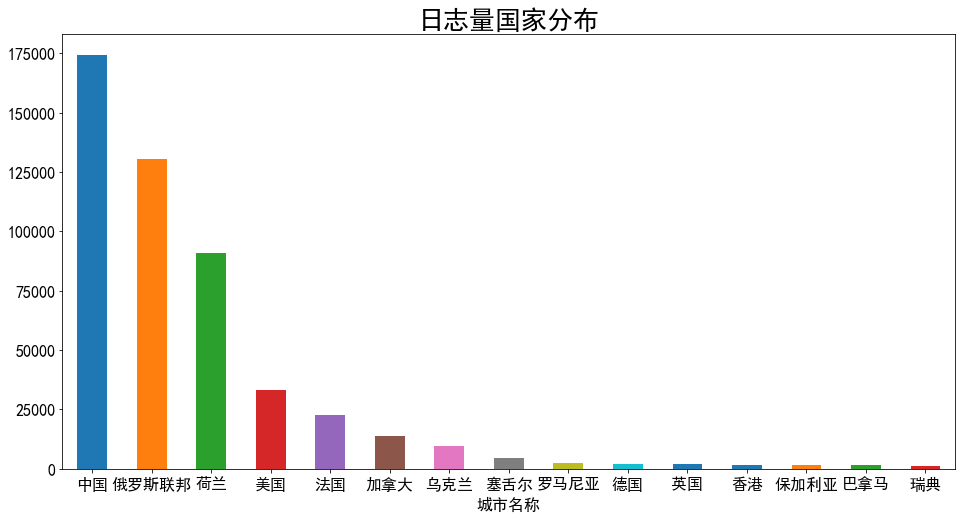

In [22]:
all_info.groupby(['coutry']).count()['src_ip'].sort_values(ascending = False)[:15].plot(kind = 'bar',figsize = (16,8),rot=360)
plt.title(u"日志量国家分布",fontsize = 16 + 10)
plt.xlabel(u"城市名称",fontsize = 16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()